In [42]:
# using Pkg
# Pkg.activate("./")

 Activating new environment at `~/Numerics/RigettiMatching/Project.toml`


In [1]:
using QSimulator 
# using Optim
# using LsqFit
# using NLsolve
# using Roots
# using QuadGK
using PyPlot
using LinearAlgebra
# using Interpolations
# using FFTW
using SpecialFunctions
# import Statistics

# import QuantumInfo: liou, avgfidelity, kraus2liou # open-source package
# import Cliffords: Z
# using Optim
using LinearAlgebra: diagm

┌ Info: Precompiling QSimulator [84ebd660-cff8-11e8-33d2-5334dd07f13c]
└ @ Base loading.jl:1260


Using local dev/QSimulator

In [2]:
# pathof(QSimulator)

In [3]:
function erfsquare_with_pads(tramp,tf,pad_length,t)
    """
    Error function square pulse
    
    :param tramp:       rise and fall time of the pulse.
    :param tf:          length of the flux pulse (without pads).
    :paramp pad_length: length of pad to be added on each side of the pulse.
    : return errfun:    error function square pulse.
    """
    fwhm = 0.5*tramp
    σ = fwhm/(2.0*sqrt(2.0 *log(2.0)))
    errfun = 0.5*(erf((t -pad_length- tramp)/σ)-erf((t + tramp - pad_length - tf)/σ))
    if t <= pad_length
        return  0
    elseif pad_length <= t <= tf+pad_length 
        return errfun
    elseif tf+pad_length  < t <= tf + 2*pad_length
    return 0
    end
end

erfsquare_with_pads (generic function with 1 method)

In [4]:
#define operators
σ0 = [0.0 1.0 0.0;0.0 0.0 √2.0;0.0 0.0 0.0]    
σz = σ0'*σ0
σ1z = [-1.0 0.0;0.0 1.0]⊗ Matrix(I,2,2)
σ2z =  Matrix(I,2,2)⊗[-1.0 0.0;0.0 1.0]
UiSWAP = [1.0 0.0 0.0 0.0 ;0.0 0.0 1im 0.0; 0.0 1im 0.0 0.0; 0.0 0.0 0.0 1.0]
UCZ = [1.0 0.0 0.0 0.0 ;0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 -1.0]
ln = [1 2 4 5 10 11 13 14 28 29 31 32 37 38 40 41] # indces of initial conditions
Iden = [1.0 0.0 0.0; 0.0 1.0 0.0]⊗[1.0 0.0 0.0; 0.0 1.0 0.0];

In [5]:
# Modulation frequencies 
fm_opt_list_CZ = [0.29297, 0.48572]
fm_opt_list_iSWAP = [0.39222]
println("modulation frequency for CZ02 = ", round(fm_opt_list_CZ[1]*1000,digits=2), " MHz")
println("modulation frequency for CZ20 = ", round(fm_opt_list_CZ[2]*1000,digits=2), " MHz")
println("modulation frequency for iSWAP = ", round(fm_opt_list_iSWAP[1]*1000,digits=2), " MHz")

modulation frequency for CZ02 = 292.97 MHz
modulation frequency for CZ20 = 485.72 MHz
modulation frequency for iSWAP = 392.22 MHz


In [6]:
# CZ GATE TIMES 
gatetime_CZ_optimal = [105.15693358991508, 174.86605293763594]

tramp = 8 # ramp time of the flux pulse
pad_length = 8 # padding on each side of the flux pulse 
tf = gatetime_CZ_optimal .+ 2*tramp
tf_with_pads = tf .+ 2*pad_length
println("CZ optimal gate times: ", gatetime_CZ_optimal)


CZ optimal gate times: [105.15693358991508, 174.86605293763594]


In [7]:
# Set up the oscillators 

# (1) fixed-frequency transmon 
f01_f, eta_f = [3.887,0.187]
q1 = DuffingTransmon("q1", 3, DuffingSpec(f01_f, -eta_f) ) 

# (2) tunable transmon
EJ_small, EJ_large, Ec = [3.0729953809760047,17.50233502578641,0.18109155430615317]
q0 = PerturbativeTransmon("q0", 3, TransmonSpec(Ec, EJ_large, EJ_small))  

# CZ02 drive for tunable transmon
phim = 0.6  # in units of Phi0. AC sweet spot amplitude


# Coupling
g01 =  0.010

0.01

In [8]:
# Fidelity of first CZ gate
lm=1

# Integration time
# times = collect(0.0:1:tf_with_pads[lm])
times = collect(0.0:1:100.0) # This is where output is written. I think QSimulator uses a smaller timestep. 
# print(times)


# CZ20 drive for tunable transmon
# driveq0 = t -> phim*erfsquare_with_pads(tramp,tf[lm],pad_length,t).*sin(2π*fm_opt_list_CZ[lm]*t)
driveq0 = t -> sin(t*1/10.)
# driveq0 = t -> 2.0*t

# First initial condition rhoin = [1,0,...]
rhoin=zeros(ComplexF64,9,9)
rhoin[1,1] = 1.0 + im*0.0
# print(rhoin)


# Construct the system 
cqs = CompositeQSystem([q0, q1])
add_hamiltonian!(cqs, q1)  # fixed transmon
add_hamiltonian!(cqs, parametric_drive(q0, driveq0), q0) # tunable transmon
add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1]) #coupling

# RUN
rho_tstop_test = me_state(cqs, times, rhoin)[end];

In [11]:
print(rho_tstop_test)

Complex{Float64}[0.9999945436013807 + 0.0im 0.0 + 0.0im -1.1642708038118037e-6 - 1.0836999617477624e-5im 0.0 + 0.0im -0.0007800447772691688 + 0.0013058079354939143im 0.0 + 0.0im 0.0008739003968630559 + 0.0015410231586077804im 0.0 + 0.0im 1.43207293586209e-6 - 3.86819810605928e-7im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; -1.1642708038118037e-6 + 1.0836999617477624e-5im 0.0 + 0.0im 1.1561372925217598e-10 + 0.0im 0.0 + 0.0im -1.53095485411579e-8 - 1.5890104078679275e-8im 0.0 + 0.0im -1.8646281740452963e-8 + 9.473567976114166e-9im 0.0 + 0.0im 3.022553208941579e-11 + 5.4000764974722604e-11im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; -0.0007800447772691688 - 0.0013058079354939143im 0.0 + 0.0im -1.53095485411579e-8 + 1.5890104078679275e-8im 0.0 + 0.0im 2.3177828837638314e-6 + 0.0im 0.0 + 0.0im 1.3345603955379982e-6 - 2.34430235450389e-6im 0.0 + 0.0im -3.074

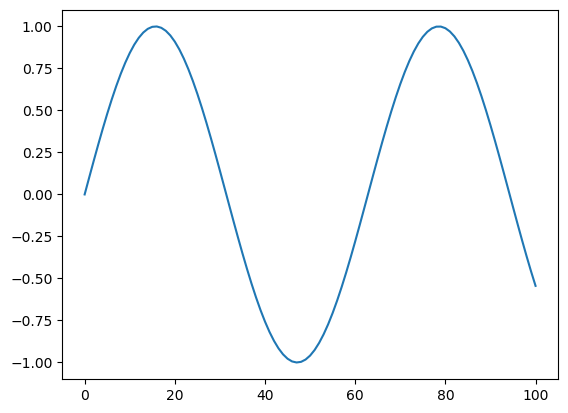

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7faf8809b150>

In [9]:
# Plot the drive
mydrive = driveq0.(times)
plot(mydrive)

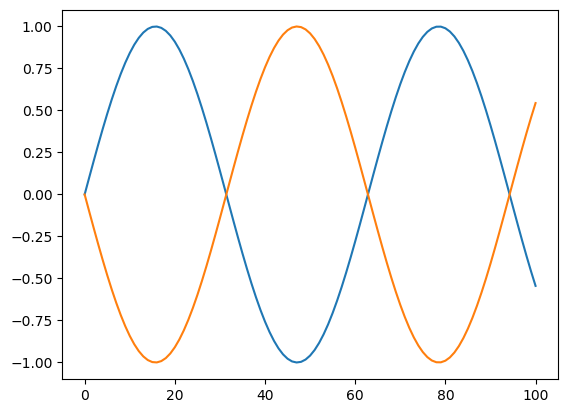

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7faf86cd4390>

In [10]:
# plot w(drive(t))
omega = perturbative_transmon_freq.(Ec, EJ_small, EJ_large, driveq0.(times))
xi = perturbative_transmon_anharm.(Ec, EJ_small, EJ_large, driveq0.(times))
plot(times, omega)
plot(times, xi)

In [40]:
# ORIGINAL: Fidelities of CZ gates with T1, T2
CZ_infidelity = []
rho_tstop = []
# for lm in 1:1:2  #iterates over gates CZ02 CZ20  
for lm in 1:1:1 
    tff = tf[lm] 
    
    times = collect(0.0:1:tf_with_pads[lm])

    rho_final = []
#     for k in 1:1:length(ln) # iterates over initial conditions
    for k in 1:1:1 # iterates over initial conditions
        IM = Matrix{ComplexF64}(I, 81,81)
        ρin = reshape(IM[:,ln[k]],9,9)
#         print("rho_in", ρin)

        cqs = CompositeQSystem([q0, q1]) # construct the composite system
        add_hamiltonian!(cqs, q1)
        add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*erfsquare_with_pads(tramp,tff,pad_length,t).*sin(2π*fm_opt_list_CZ[lm]*t)), q0)
#         add_hamiltonian!(cqs, parametric_drive(q0, driveq0), q0)
        add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1])
#         println(hamiltonian(cqs))
#         stop


#         add_lindblad!(cqs, sqrt(γ1t)*σ0, [q0])
#         add_lindblad!(cqs, sqrt(γϕt)*σz, [q0])
#         add_lindblad!(cqs, sqrt(γ1f)*σ0, [q1])
#         add_lindblad!(cqs, sqrt(γϕf)*σz, [q1])
        ρs = me_state(cqs, times, ρin);
#         print("rho_tstop = ", ρs[end])
        rho_tstop = ρs[end]
        
        ρf = Iden*reshape(ρs[end],9,9)*Iden' # project on to the computational subspace
        append!(rho_final,   [reshape(ρf,16,1)])
    end
#     UCZ = diagm(0 => [1.0,1.0,1.0,-1.0])
#     final_process_matrix  = hcat([rho_final[l] for l=1:length(ln)]...)     # noisey process matrix
#     push!(CZ_infidelity, infidelity(final_process_matrix,UCZ,zeros(2)))
end

In [39]:
print("ERROR=", norm(rho_tstop - rho_tstop_test))

ERROR=0.00106477696533778